In [1]:
from mlinspect.monkeypatching._mlinspect_ndarray import MlinspectNdarray
import pandas as pd
import os
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from mlinspect.utils import get_project_root
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# prepare data for explainer
COUNTIES_OF_INTEREST = ['county2', 'county3']

patients = pd.read_csv(os.path.join(str(get_project_root()), "example_pipelines", "healthcare",
                                    "patients.csv"), na_values='?')
histories = pd.read_csv(os.path.join(str(get_project_root()), "example_pipelines", "healthcare",
                                     "histories.csv"), na_values='?')

data = patients.merge(histories, on=['ssn'])
complications = data.groupby('age_group') \
    .agg(mean_complications=('complications', 'mean'))
data = data.merge(complications, on=['age_group'])
data['label'] = data['complications'] > 1.2 * data['mean_complications']
data = data[['smoker', 'last_name', 'county', 'num_children', 'race', 'income', 'label']]
data = data[data['county'].isin(COUNTIES_OF_INTEREST)]
train_data, test_data = train_test_split(data)
y_train = train_data["label"]
y_test = test_data["label"]
X_train = train_data.drop("label", axis=1)
X_test = test_data.drop("label", axis=1)

impute_and_one_hot_encode = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])
featurisation = ColumnTransformer(transformers=[
    ("impute_and_one_hot_encode", impute_and_one_hot_encode, ['smoker', 'county', 'race']),
    ('numeric', StandardScaler(), ['num_children', 'income']),
], remainder='drop')

X_t_train: MlinspectNdarray = featurisation.fit_transform(train_data, y_train)
print(featurisation.get_feature_names_out())
X_t_test: MlinspectNdarray = featurisation.fit_transform(X_test, y_test)

['impute_and_one_hot_encode__smoker_False'
 'impute_and_one_hot_encode__smoker_True'
 'impute_and_one_hot_encode__county_county2'
 'impute_and_one_hot_encode__county_county3'
 'impute_and_one_hot_encode__race_race1'
 'impute_and_one_hot_encode__race_race2'
 'impute_and_one_hot_encode__race_race3' 'numeric__num_children'
 'numeric__income']


/opt/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
import numpy as np
from features.explainability.inspections.explainability_methods_enum import ExplainabilityMethodsEnum
from features.explainability.inspections.explainer import Explainer
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Some tensorflow warnings in the pipeline we inspect
from mlinspect.utils import get_project_root

from mlinspect import PipelineInspector

EXAMPLE_PIPELINE = os.path.join(str(get_project_root()), "features", "explainability", "examples", "test_pipeline.py")

inspector_result = PipelineInspector\
    .on_pipeline_from_py_file(EXAMPLE_PIPELINE) \
    .add_required_inspection(Explainer([ExplainabilityMethodsEnum.DALE,], X_t_train.view(np.ndarray), X_t_test.view(np.ndarray), featurisation.get_feature_names_out(), y_test, y_train)) \
    .execute()

extracted_dag = inspector_result.dag
dag_node_to_inspection_results = inspector_result.dag_node_to_inspection_results
check_results = inspector_result.check_to_check_results

Mean accuracy: 0.9178082191780822


In [3]:
from mlinspect import OperatorType

relevant_node = [node for node in extracted_dag.nodes if node.operator_info.operator in {OperatorType.ESTIMATOR,}][0]
print("\n\033[1m{} ({})\033[0m\n{}\n{}".format(
    relevant_node.operator_info.operator,
    relevant_node.details.description,
    relevant_node.optional_code_info.source_code,
    relevant_node.optional_code_info.code_reference))
inspection_result = dag_node_to_inspection_results[relevant_node][Explainer([ExplainabilityMethodsEnum.DALE,], X_t_train.view(np.ndarray), X_t_test.view(np.ndarray), featurisation.get_feature_names_out(),y_test, y_train)]
print(inspection_result)


OperatorType.ESTIMATOR (Neural Network)
KerasClassifier(
    model=create_model_predict,
    epochs=10,
    batch_size=1,
    verbose=0,
    loss="binary_crossentropy",
)
CodeReference(lineno=86, col_offset=13, end_lineno=92, end_col_offset=1)
{<ExplainabilityMethodsEnum.DALE: 'Differential Accumulated Local Effects'>: {'explainer': <features.explainability.dale.dale.DALE object at 0xffff401706d0>, 'results': (array([[ 5.96748224e-02, -4.92317285e-02, -4.92317285e-02, ...,
         5.96748224e-02,  5.96748224e-02,  5.60492810e-02],
       [-4.92317285e-02,  5.96748224e-02, -4.92317285e-02, ...,
         5.96748224e-02,  9.10696819e-03, -6.69174241e-05],
       [-4.92317285e-02,  5.96748224e-02, -4.92317285e-02, ...,
         5.96748224e-02,  5.96748224e-02,  5.96748224e-02],
       ...,
       [ 5.96748224e-02, -4.92317285e-02, -4.92317285e-02, ...,
         5.96748224e-02, -4.92317285e-02, -2.19979819e-02],
       [-4.92317285e-02,  5.96748224e-02, -4.92317285e-02, ...,
         5.96

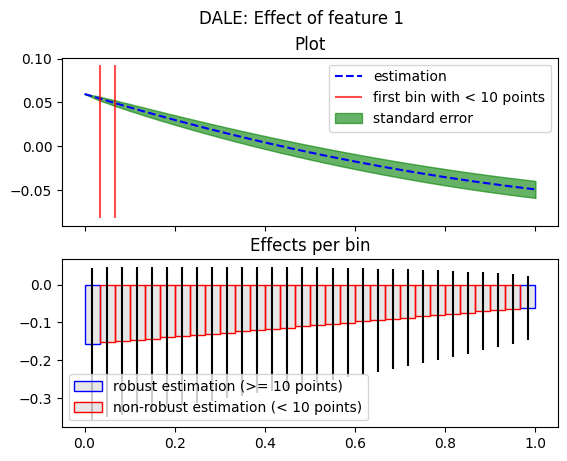

In [4]:
inspection_result[ExplainabilityMethodsEnum.DALE]["explainer"].plot()